In [2]:
# explore_kaggle.ipynb

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sqlite3
import datetime
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [95]:
# connect to dataset
cnx = sqlite3.connect("FPA_FOD_20170508.sqlite")
kaggle = pd.read_sql_query("SELECT * FROM Fires LIMIT 1000", cnx)

In [96]:
kaggle.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [97]:
kaggle.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [98]:
# we are dropping columns which upon analysis do not have much to offer for learning
# mostly things like unique identifiers which could be used to visit national websites
kaggle = kaggle[[
    'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR',
    'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY'
    ]]

In [99]:
kaggle.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY
0,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,CA,63
1,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,CA,61
2,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,CA,17
3,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,CA,3
4,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,CA,3


In [100]:
"""
Steps we have to complete:
1. Convert latitude, longitude coords to standardized forms
    a. https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature
    b. Note that the extremes of these are actually really close together
    c. To account for this, we will use the following formulas to get (x, y, z) coords. Note that:
        * the x-axis goes through long,lat (0,0), so longitude 0 meets the equator
        * the y-axis goes through (0,90)
        * and the z-axis goes through the poles

        x = cos(lat) * cos(lon)
        y = cos(lat) * sin(lon)
        z = sin(lat)
2. Convert the date stuff to an actual timestamp and calculated duration
3. Scale the columns which are numerical
4. Convert the string columns to appropriate numerical categories
"""

# Step 1:

kaggle['X_COORD'] = np.cos(kaggle['LATITUDE']) * np.cos(kaggle['LONGITUDE'])
kaggle['Y_COORD'] = np.cos(kaggle['LATITUDE']) * np.sin(kaggle['LONGITUDE'])
kaggle['Z_COORD'] = np.sin(kaggle['LATITUDE'])
# we no longer need the latitude or longitude columns
kaggle = kaggle.drop(['LATITUDE', 'LONGITUDE'], axis=1)

In [3]:
kaggle.head()
print(len(kaggle))

NameError: name 'kaggle' is not defined

In [102]:
# Step 2
"""
We will replace FIRE_YEAR with a timestamp that is calculated based on the additional information from DISCOVERY_DOY, DISCOVERY_TIME, CONT_DOY, CONT_TIME
This is because we can convert FIRE_YEAR into a continuous(ish) variable in order to later graph or perform regression, and individual years do not provide
too much information (since we cannot turn it into a category for future data as future data would be moving forward in time)

DOY and TIME information is useful for categorizing or predicting items like severity because there is information in the day of year on which
the fire took place (ex. a fire happening during the winter days vs. a fire in the summer days,
or fires at night [low response time] compared to fires in the day [high response time])

Thus, we won't remove day of year and time but instead normalize them as continuous variables.

We will remove _DATE columns because I cannot understand how they should be interpreted.
"""
s = kaggle['DISCOVERY_TIME'].str
kaggle['DISCOVERY_TIMESTAMP'] = pd.to_datetime(kaggle['FIRE_YEAR'], format="%Y") + pd.to_timedelta(kaggle['DISCOVERY_DOY'], unit='d') + pd.to_timedelta(s[0:2].astype(int), unit='h') + pd.to_timedelta(s[2:4].astype(int), unit='m')

kaggle['DISCOVERY_TIME'] = s[0:2].astype(int) * 60 + s[2:4].astype(int)

s = kaggle['CONT_TIME'].fillna('0000').str
kaggle['CONTAINED_TIMESTAMP'] = pd.to_datetime(kaggle['FIRE_YEAR'], format="%Y") + pd.to_timedelta(kaggle['CONT_DOY'], unit='d') + pd.to_timedelta(s[0:2].astype(int), unit='h') + pd.to_timedelta(s[2:4].astype(int), unit='m')
kaggle['CONT_TIME'] = s[0:2].astype(int) * 60 + s[2:4].astype(int)

kaggle['FIRE_DURATION'] = kaggle['CONTAINED_TIMESTAMP'] - kaggle['DISCOVERY_TIMESTAMP']

kaggle = kaggle.drop(['DISCOVERY_DATE', 'CONT_DATE', 'FIRE_YEAR'], axis=1)

kaggle['STAT_CAUSE_CODE'] = kaggle['STAT_CAUSE_CODE'].astype(int)
kaggle['CONT_DOY'] = kaggle['CONT_DOY'].fillna(kaggle['DISCOVERY_DOY'] + 3).astype(int)

In [118]:
kaggle.head()

,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,STATE,COUNTY,X_COORD,Y_COORD,Z_COORD,DISCOVERY_TIMESTAMP,CONTAINED_TIMESTAMP,FIRE_DURATION
0,33,780,9,Miscellaneous,33,1050,0.10,A,CA,63,0.037816,0.692973,0.719971,2005-02-03 13:00:00,2005-02-03 17:30:00,0 days 04:30:00
1,133,525,1,Lightning,133,930,0.25,A,CA,61,0.171876,-0.282314,0.943800,2004-05-13 08:45:00,2004-05-13 15:30:00,0 days 06:45:00
2,152,1161,5,Debris Burning,152,1224,0.10,A,CA,17,0.060346,-0.275333,0.959453,2004-06-01 19:21:00,2004-06-01 20:24:00,0 days 01:03:00
3,180,960,1,Lightning,185,840,0.10,A,CA,3,0.561962,-0.331390,0.757878,2004-06-29 16:00:00,2004-07-04 14:00:00,4 days 22:00:00
4,180,960,1,Lightning,185,720,0.10,A,CA,3,0.555317,-0.342408,0.757878,2004-06-29 16:00:00,2004-07-04 12:00:00,4 days 20:00:00


In [133]:
# kaggle.to_csv("sample_kaggle.csv")
# Step 3
"""
Now we have to properly scale the continuous variables so PCA can properly do its thing
We will use scikit learn's StandardScaler

Note we are not scaling the categorical data since we won't use it for PCA (and we can't scale categorical data)
https://stackoverflow.com/questions/48673402/how-can-i-standardize-only-numeric-variables-in-an-sklearn-pipeline
"""
# convert duration into float seconds
# kaggle['FIRE_DURATION'] = kaggle['FIRE_DURATION'].dt.seconds
continuous = ['DISCOVERY_DOY', 'DISCOVERY_TIME', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'X_COORD', 'Y_COORD', 'Z_COORD', 'FIRE_DURATION']
kaggle[continuous] = StandardScaler().fit_transform(kaggle[continuous])

In [134]:
kaggle.head()

,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,STATE,COUNTY,X_COORD,Y_COORD,Z_COORD,DISCOVERY_TIMESTAMP,CONTAINED_TIMESTAMP,FIRE_DURATION
0,-2.972921,-0.228133,9,Miscellaneous,-2.976087,0.537126,-0.067036,A,CA,63,0.015709,1.666538,1.127728,2005-02-03 13:00:00,2005-02-03 17:30:00,-0.191158
1,-0.829812,-1.279628,1,Lightning,-0.839812,0.058191,-0.066843,A,CA,61,0.277779,-0.412192,1.443316,2004-05-13 08:45:00,2004-05-13 15:30:00,0.137110
2,-0.422621,1.342924,5,Debris Burning,-0.433920,1.231581,-0.067036,A,CA,17,0.059752,-0.397314,1.465387,2004-06-01 19:21:00,2004-06-01 20:24:00,-0.694501
3,0.177449,0.514099,1,Lightning,0.271051,-0.301011,-0.067036,A,CA,3,1.040347,-0.516792,1.181176,2004-06-29 16:00:00,2004-07-04 14:00:00,2.362034
4,0.177449,0.514099,1,Lightning,0.271051,-0.779946,-0.067036,A,CA,3,1.027357,-0.540276,1.181176,2004-06-29 16:00:00,2004-07-04 12:00:00,2.070241


In [140]:
continuous_df = kaggle[continuous]

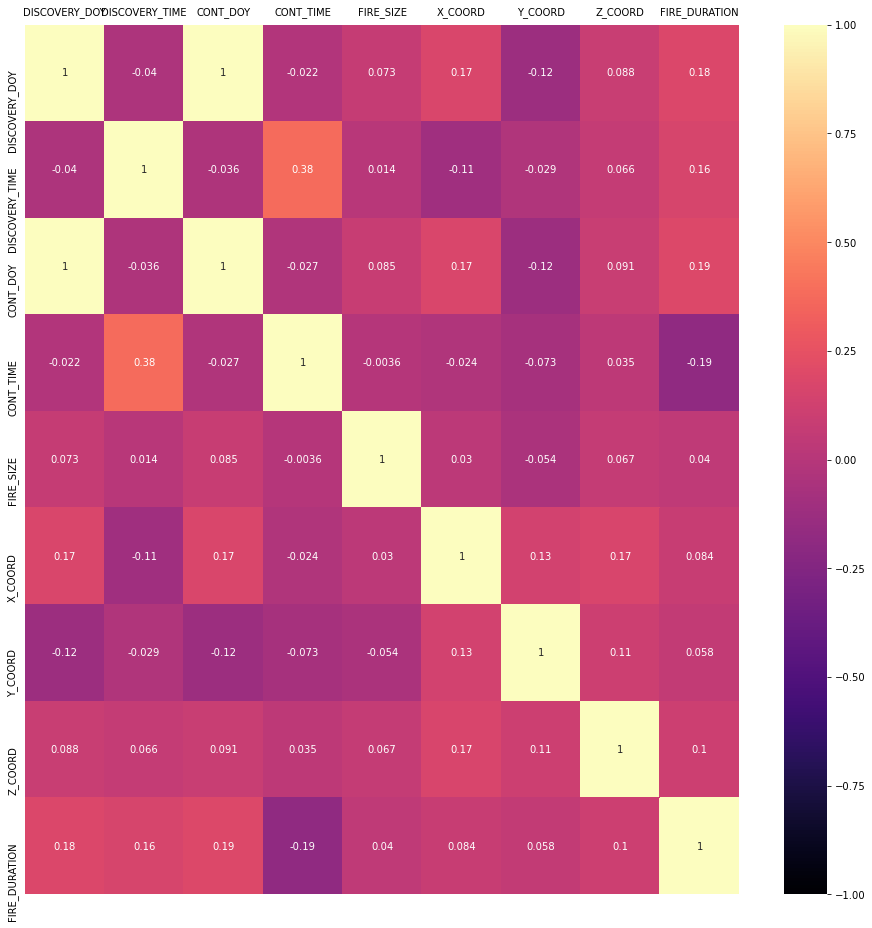

In [141]:
# creating the correlation figure using corr_df
# we are only using the continuous variables
plt.figure(figsize=(16, 16))
ax = sns.heatmap(continuous_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='magma')
ax.tick_params(axis='both', which='both', labelsize=10, labelbottom = False, left=False, bottom=False, top = False, labeltop=True)

In [148]:
# Step 3
# Realize that PCA is good for continuous variables, so we shouldn't use it on categorical data
# One way, only apply pca on the continuous variables and manually append the categorical variables after
# pca is completed

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(continuous_df.fillna(0))

In [152]:
principal_df = pd.DataFrame(data=principalComponents, columns=['principalComp1', 'principalComp2'])

In [153]:
principal_df

,principalComp1,principalComp2
0,-3.917449,0.731294
1,-0.702512,0.842313
2,-0.620299,-1.766922
3,1.300602,0.017487
4,1.264858,0.307339
...,...,...
995,1.865036,0.420571
996,-3.343890,0.291569
997,-2.107402,-0.359276
998,-2.115181,-0.586421


In [156]:
final_df = pd.concat([principal_df, kaggle[['FIRE_SIZE_CLASS']]], axis = 1)

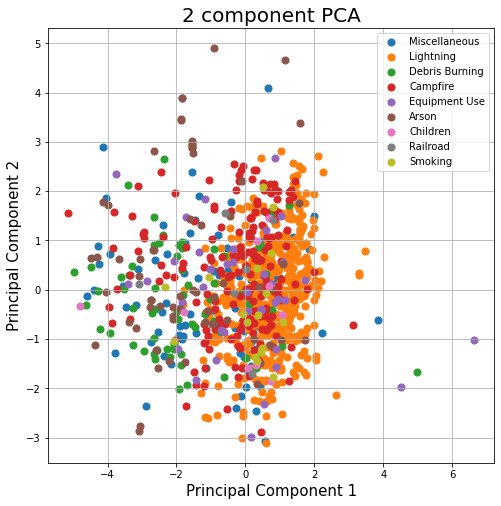

In [171]:
targets = kaggle['STAT_CAUSE_DESCR'].unique()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
for target in targets:
    tIndices = kaggle['STAT_CAUSE_DESCR'] == target
    ax.scatter(
        final_df.loc[tIndices, 'principalComp1'],
        final_df.loc[tIndices, 'principalComp2'],
        s=50
    )
ax.legend(targets)
ax.grid()

In [166]:
pca.explained_variance_ratio_

array([0.2426723 , 0.15757375])

In [168]:
pcaTest = PCA(0.95)
principalComponents = pcaTest.fit_transform(continuous_df.fillna(0))

In [169]:
pcaTest.explained_variance_ratio_

array([0.2426723 , 0.15757375, 0.14232368, 0.11625856, 0.11148645,
       0.09012832, 0.08576248, 0.05373637])